In [40]:
from sudoku import Board
import cv2
import seaborn as sns
import operator
%matplotlib inline

In [49]:
img = cv2.imread('board.jpeg', cv2.IMREAD_GRAYSCALE)
original = img

In [68]:
def pre_process_image(img, dilate=False):
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    proc = cv2.bitwise_not(proc, proc)
    if dilate:
#         kernel = np.ones((3,3),np.uint8)
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
        proc = cv2.dilate(proc, kernel)
    return proc


def find_corners_of_largest_polygon(img):
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    polygon = contours[0]  # Largest image
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

def distance(p1, p2):
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

def crop_and_warp(img, crop_rect):
    """Crops and warps a rectangular section from an image into a square of similar size."""
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')
    side = max([
        distance(bottom_right, top_right),
        distance(top_left, bottom_left),
        distance(bottom_right, bottom_left),
        distance(top_left, top_right)
    ])
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
    m = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, m, (int(side), int(side)))

def infer_grid(img):
    squares = []
    side = img.shape[:1]
    side = side[0] / 9
    for i in range(9):
        for j in range(9):
            p1 = (i * side, j * side)
            p2 = ((i + 1) * side, (j + 1) * side)
            squares.append((p1, p2))
    return squares

def cut_from_rect(img, rect):
    return img[int(rect[0][1]):int(rect[1][1]), int(rect[0][0]):int(rect[1][0])]

In [69]:
def scale_and_centre(img, size, margin=0, background=0):
    """Scales and centres an image onto a new background square."""
    h, w = img.shape[:2]

    def centre_pad(length):
        """Handles centering for a given length that may be odd or even."""
        if length % 2 == 0:
            side1 = int((size - length) / 2)
            side2 = side1
        else:
            side1 = int((size - length) / 2)
            side2 = side1 + 1
        return side1, side2

    def scale(r, x):
        return int(r * x)

    if h > w:
        t_pad = int(margin / 2)
        b_pad = t_pad
        ratio = (size - margin) / h
        w, h = scale(ratio, w), scale(ratio, h)
        l_pad, r_pad = centre_pad(w)
    else:
        l_pad = int(margin / 2)
        r_pad = l_pad
        ratio = (size - margin) / w
        w, h = scale(ratio, w), scale(ratio, h)
        t_pad, b_pad = centre_pad(h)

    img = cv2.resize(img, (w, h))
    img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
    return cv2.resize(img, (size, size))


def find_largest_feature(inp_img, scan_tl=None, scan_br=None):
    img = inp_img.copy()  # Copy the image, leaving the original untouched
    height, width = img.shape[:2]
    max_area = 0
    seed_point = (None, None)
    if scan_tl is None:
        scan_tl = [0, 0]
    if scan_br is None:
        scan_br = [width, height]
    # Loop through the image
    for x in range(scan_tl[0], scan_br[0]):
        for y in range(scan_tl[1], scan_br[1]):
            # Only operate on light or white squares
            if img.item(y, x) == 255 and x < width and y < height:  # Note that .item() appears to take input as y, x
                area = cv2.floodFill(img, None, (x, y), 64)
                if area[0] > max_area:  # Gets the maximum bound area which should be the grid
                    max_area = area[0]
                    seed_point = (x, y)
    # Colour everything grey (compensates for features outside of our middle scanning range
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 255 and x < width and y < height:
                cv2.floodFill(img, None, (x, y), 64)
    mask = np.zeros((height + 2, width + 2), np.uint8)  # Mask that is 2 pixels bigger than the image
    # Highlight the main feature
    if all([p is not None for p in seed_point]):
        cv2.floodFill(img, mask, seed_point, 255)
    top, bottom, left, right = height, 0, width, 0
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 64:  # Hide anything that isn't the main feature
                cv2.floodFill(img, mask, (x, y), 0)

            # Find the bounding parameters
            if img.item(y, x) == 255:
                top = y if y < top else top
                bottom = y if y > bottom else bottom
                left = x if x < left else left
                right = x if x > right else right

    bbox = [[left, top], [right, bottom]]
    return img, np.array(bbox, dtype='float32'), seed_point

def extract_digit(img, rect, size):
    """Extracts a digit (if one exists) from a Sudoku square."""
    digit = cut_from_rect(img, rect)  # Get the digit box from the whole square
    # Use fill feature finding to get the largest feature in middle of the box
    # Margin used to define an area in the middle we would expect to find a pixel belonging to the digit
    h, w = digit.shape[:2]
    margin = int(np.mean([h, w]) / 2.5)
    _, bbox, seed = find_largest_feature(digit, [margin, margin], [w - margin, h - margin])
    digit = cut_from_rect(digit, bbox)
    # Scale and pad the digit so that it fits a square of the digit size we're using for machine learning
    w = bbox[1][0] - bbox[0][0]
    h = bbox[1][1] - bbox[0][1]
    # Ignore any small bounding boxes
    if w > 0 and h > 0 and (w * h) > 100 and len(digit) > 0:
        return scale_and_centre(digit, size, 4)
    else:
        return np.zeros((size, size), np.uint8)

def get_digits(img, squares, size):
    """Extracts digits from their cells and builds an array"""
    digits = []
    img = pre_process_image(img.copy(), dilate=True)
    for square in squares:
        digits.append(extract_digit(img, square, size))
    return digits

In [70]:
processed = pre_process_image(img, dilate=True)
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(original, corners)
squares = infer_grid(cropped)
digits = get_digits(cropped, squares, 28)

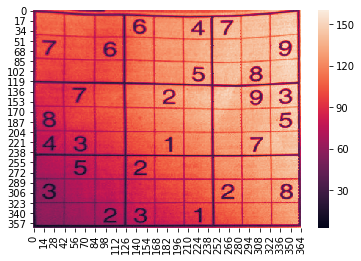

In [53]:
sns.heatmap(cropped)

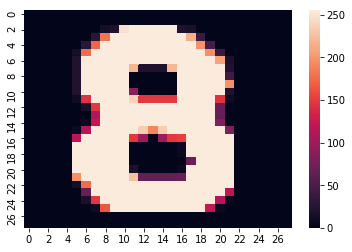

In [74]:
sns.heatmap(digits[4])